# Introduction
---

This notebook is the first part of a Data Science Project that aims to predict the age and gender of people based on the 
[UTKFace Dataset](https://www.kaggle.com/abhikjha/utk-face-cropped).

In this particular notebook I will prepare our data and save as TFRecord files. TFRecords are the best way to storage a huge amount of data and use it to train Keras Models. You can check how to use it in: [A hands-on guide to TFRecords](https://towardsdatascience.com/a-practical-guide-to-tfrecords-584536bc786c)

Make sure to check the other notebooks of this project as well:


Without further ado, let's start!

### Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
from PIL import Image

# Reading Data
----

In [2]:
curdir = "../input/utk-face-cropped/utkcropped"

In [3]:
dataset_filepaths = os.listdir(curdir)

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
np.random.shuffle(dataset_filepaths)

In [6]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

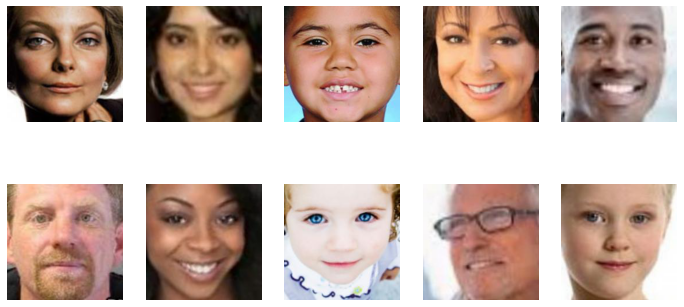

In [7]:
fig, ax = plt.subplots(2,5, figsize=(12, 6), sharex=True, sharey=True)
for image_idx in range(10):
    ax[image_idx//5, image_idx%5].imshow(Image.open(os.path.join(curdir,dataset_filepaths[image_idx])))
    ax[image_idx//5, image_idx%5].axis('off')
plt.show()

In [8]:
def create_example(folder_path, filepath):
    full_path = os.path.join(folder_path, filepath)
    image = tf.io.serialize_tensor(np.array(Image.open(full_path)))
    split = filepath.split("_")
    age = int(split[0])
    gender = int(split[1])
    
    example = Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image.numpy()])),
                "age": Feature(int64_list=Int64List(value=[age])),
                "gender": Feature(int64_list=Int64List(value=[gender])),
            }
        )
    )
    return example

In [9]:
def create_tf_record(set_, filename):
    with tf.io.TFRecordWriter("%s.tfrecord" %filename) as f:
        for filepath in set_:
            if filepath != "utkcropped":
                example = create_example(curdir, filepath)
                f.write(example.SerializeToString())

In [10]:
create_tf_record(dataset_filepaths[:16597], "train_data")


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'


In [11]:
create_tf_record(dataset_filepaths[16597:18968], "valid_data")

In [12]:
create_tf_record(dataset_filepaths[18968:], "test_data")

That's it! Now that we have saved our data in TFRecords file, let's use a pretrained model to predict our gender and age.
If you enjoyed this notebook, please let me know! And tell me how can I improve it! 

Check it out the next notebook of this series:
